<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/Attention_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import torch
import random
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from torchtext import data
from transformers import BertTokenizer, BertModel

In [0]:
args = {
    "bert_tokenizer": "bert-base-uncased",
    "bert_pretrained_model": "bert-base-uncased",
    "seed": 1234,
    "batch_size": 64,
    "num_filters": 100,
    "filter_sizes": [3,4,5],
    "output_dim": 11,
    "dropout": 0.5,
    "epochs": 10
}

In [8]:
tokenizer = BertTokenizer.from_pretrained(args['bert_tokenizer'])

In [9]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [10]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [13]:
max_input_length = tokenizer.max_model_input_sizes[args['bert_tokenizer']]

print(max_input_length)

512


In [0]:
def tokenize_and_cut(tweet):
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  return tokens

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')

random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = True

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token= None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = args['batch_size'],
    device = device
)

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if aux == 20: break;

In [19]:
bert = BertModel.from_pretrained(args['bert_pretrained_model'])

In [0]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()
    self.attention = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = torch.tanh(x)
    x = self.attention(x).squeeze(2)
    alpha = F.softmax(x, dim=1).unsqueeze(1)
    return alpha

class AttentionBiLSTM(nn.Module):
  def __init__(self, bert, hidden_size, num_layers, dropout, fc_dropout, 
               embed_dropout, num_classes):
    super(AttentionBiLSTM, self).__init__()

    self.hidden_size = hidden_size 
    self.bert = bert 
    embedding_dim = 768 

    self.embed_dropout = nn.Dropout(embed_dropout)

    self.bilstm = nn.LSTM(embedding_dim, 
                          hidden_size, 
                          num_layers, 
                          dropout=(0 if num_layers==1 else dropout),
                          bidirectional=True,
                          batch_first=True)
    
    self.fc = nn.Linear(hidden_size, num_classes)
    self.fc_dropout = nn.Dropout(fc_dropout)
    
    self.attention = Attention(hidden_size)
  
  def forward(self, text):
    with torch.no_grad():
      x = self.bert(text)[0]
    
    x = self.embed_dropout(x)
    y, _ = self.bilstm(x)
    y = y[:,:,:self.hidden_size] + y[:,:,self.hidden_size:]
    alpha = self.attention(y)
    r = alpha.bmm(y).squeeze(1)
    h = torch.tanh(r)
    logits = self.fc(h)
    logits = self.fc_dropout(logits)
    return logits

In [167]:
model = AttentionBiLSTM(
    bert=bert,
    hidden_size=768,
    num_layers=2,
    dropout=0.5,
    fc_dropout=0.5,
    embed_dropout=0.2,
    num_classes=11,
)

model

AttentionBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [0]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [169]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

bilstm.weight_ih_l0
bilstm.weight_hh_l0
bilstm.bias_ih_l0
bilstm.bias_hh_l0
bilstm.weight_ih_l0_reverse
bilstm.weight_hh_l0_reverse
bilstm.bias_ih_l0_reverse
bilstm.bias_hh_l0_reverse
bilstm.weight_ih_l1
bilstm.weight_hh_l1
bilstm.bias_ih_l1
bilstm.bias_hh_l1
bilstm.weight_ih_l1_reverse
bilstm.weight_hh_l1_reverse
bilstm.bias_ih_l1_reverse
bilstm.bias_hh_l1_reverse
fc.weight
fc.bias
attention.attention.weight
attention.attention.bias


In [0]:
import torch.optim as optim 

In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
from sklearn.metrics import roc_auc_score, f1_score

In [0]:
def metricize(preds, y):
  f1_macro = f1_score(y, preds.round(), average='macro')
  f1_micro = f1_score(y, preds.round(), average='micro')
  acc = roc_auc_score(y, preds)

  return {
      'f1_macro': f1_macro,
      'f1_micro': f1_micro,
      'acc': acc
  }

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()

    predictions = model(batch.Tweet)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item()
  
  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0

  model.eval()

  preds_list = []
  labels_list = []

  with torch.no_grad():
    
    for batch in iterator:

      predictions = model(batch.Tweet)

      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [177]:
best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(args['epochs']):

    start_time = time.time()
    
    train_loss, train_metrics = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_metrics = evaluate(model, valid_iterator, criterion)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert-lstm-model.pt')

    train_acc = train_metrics['acc']
    train_micro = train_metrics['f1_micro']
    train_macro = train_metrics['f1_macro']

    valid_acc = valid_metrics['acc']
    valid_micro = valid_metrics['f1_micro']
    valid_macro = valid_metrics['f1_macro']
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train F1 Micro: {train_micro*100:.2f}% | Train F1 Macro: {train_macro*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%  | Val. F1 Micro: {valid_micro*100:.2f}%  | Val. F1 Macro: {valid_macro*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 0.555 | Train Acc: 58.90% | Train F1 Micro: 27.74% | Train F1 Macro: 17.15%
	 Val. Loss: 0.427 | Val. Acc: 79.95%  | Val. F1 Micro: 54.03%  | Val. F1 Macro: 32.68%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 0.526 | Train Acc: 63.97% | Train F1 Micro: 34.99% | Train F1 Macro: 23.09%
	 Val. Loss: 0.383 | Val. Acc: 83.37%  | Val. F1 Micro: 64.36%  | Val. F1 Macro: 43.12%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 0.511 | Train Acc: 66.26% | Train F1 Micro: 38.69% | Train F1 Macro: 27.33%
	 Val. Loss: 0.363 | Val. Acc: 85.24%  | Val. F1 Micro: 65.50%  | Val. F1 Macro: 46.33%
Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.508 | Train Acc: 66.83% | Train F1 Micro: 40.57% | Train F1 Macro: 29.18%
	 Val. Loss: 0.359 | Val. Acc: 85.26%  | Val. F1 Micro: 66.17%  | Val. F1 Macro: 47.44%
Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.500 | Train Acc: 68.42% | Train F1 Micro: 41.17% | Train F1 Macro: 30.57%
	 Val. Loss: 0.352 | Val. Acc: 85.62%  | Val. F1

In [0]:
import matplotlib.pyplot as plt

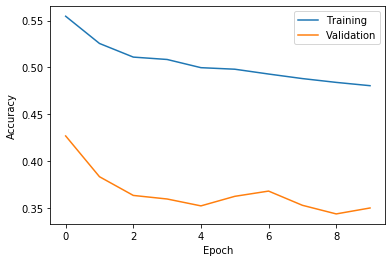

In [179]:
plt.plot(train_history)
plt.plot(valid_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

In [180]:
model.load_state_dict(torch.load('bert-lstm-model.pt'))

test_loss, test_metrics = evaluate(model, test_iterator, criterion)

test_acc = test_metrics['acc']
test_micro = test_metrics['f1_micro']
test_macro = test_metrics['f1_macro']

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1 Micro: {test_micro*100:.2f}% | Test F1 Macro: {test_macro*100:.2f}%')

Test Loss: 0.343 | Test Acc: 84.83% | Test F1 Micro: 66.70% | Test F1 Macro: 52.13%


# Inference

In [0]:
def predict_emotion(model, tokenizer, tweet):
  preds = []
  model.eval()
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  predictions = model(tensor)
  preds.append(torch.sigmoid(predictions).detach().cpu().numpy())
  #preds += [torch.sigmoid(predictions).detach().cpu().numpy()]
  return preds

In [182]:
preds = predict_emotion(model, tokenizer, "I am looking forward to tomorrow, cant wait!")

vals = []
for p in preds[0]:
  for val in p:
    vals.append(val)

for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {vals[i]}")

ANGER: 0.10629309713840485
ANTICIPATION: 0.778019905090332
DISGUST: 0.05884477496147156
FEAR: 0.33717355132102966
JOY: 0.8220938444137573
LOVE: 0.16540677845478058
OPTIMISM: 0.6468307971954346
PESSIMISM: 0.11236879974603653
SADNESS: 0.18104545772075653
SURPRISE: 0.10060752928256989
TRUST: 0.19814808666706085
